# Diode notebook

## How to use the diode to test the timing of your stimulus wrt your triggers

In [10]:
%matplotlib inline
#%matplotlib widget

In [13]:
#importing modules
import os
import pip

import numpy as np
%pip install mne
import mne # type: ignore

%pip install pandas
%pip install scikit-learn


import pandas as pd
import sklearn

import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from pathlib import Path


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
# reading the file & loading in the data
# Define the subject and file path
eeg_subj = 'Group12_own'
data_raw_file = os.path.join("/Users/lina/Documents/GitHub/ore_EEG/data/", eeg_subj + '.vhdr')

raw = mne.io.read_raw_brainvision(data_raw_file, eog = ('HEOG', 'VEOG'), misc = ["41"])
raw.info['bads'] = []

raw.load_data()

Extracting parameters from /Users/lina/Documents/GitHub/ore_EEG/data/Group12_own.vhdr...
Setting channel info structure...


/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_12939/3634630922.py:6: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(data_raw_file, eog = ('HEOG', 'VEOG'), misc = ["41"])


FileNotFoundError: [Errno 2] No such file or directory: '/Users/lina/Documents/GitHub/ore_EEG/data/Group12_own.eeg'

### Setting montage and common ave referencing

In [ ]:
# selecting only EEG and stimulus data & plotting raw data
montage = mne.channels.make_standard_montage('standard_1020')

raw.set_montage(montage, verbose=False)
#raw.pick_types(meg=False, eeg=True, eog=True, stim=True, exclude=[])
raw.pick_types(meg=False, eeg=True, eog=True, misc=True, exclude=[])
raw.set_eeg_reference(ref_channels='average', ch_type='eeg')

## [Straight to] Epoching
We now want to create epochs according to the events in our data, e.g. stimuli presentation. First, we locate the events and name our event IDs.

In [24]:
# this function locates any stimulus events in the recording (e.g. presentation of stimuli or button presses)
events, events_id = mne.events_from_annotations(raw)

np.unique(events[:,2])

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 50', 'Stimulus/S100', 'Stimulus/S118', 'Stimulus/S200', 'Stimulus/S250']


array([   50,   100,   118,   200,   250, 99999])

In [25]:
# deleting spurious triggers (e.g. from the trigger not be re-set between triggers events)
#If dif < 2 for trigger onsets, then reject preceding trial - i.e. if there's only 1 ms between triggers
dif_onsets = np.diff(events[:,0])
dif_idx = np.where(dif_onsets<2)[0]
events = np.delete(events, dif_idx, axis = 0)
print('event number {} was rejected'.format(dif_idx))

event number [  2 149 151] was rejected


In [26]:
# we can make a dictionary of what the event IDs represent
# creating an event_id for epoching

event_id = {
    "Start": 50,
    "Standard": 200,
    "Deviant": 100,
}

/tmp/ipykernel_346/1334847944.py:2: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=1000, first_samp=raw.first_samp, event_id=event_id);


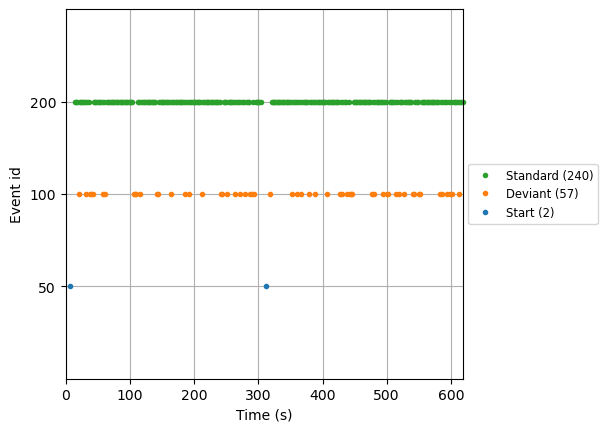

In [27]:
# plotting an overview of the events
mne.viz.plot_events(events, sfreq=1000, first_samp=raw.first_samp, event_id=event_id); 

In [28]:
# for diode timings
#tmin_d, tmax_d = -0.05, 0.1  # in s - setting a very narrow window around the trigger (=0) to be able to better inspect potential delays
tmin_d, tmax_d = -0.01, 0.05  # in s - setting a very narrow window around the trigger (=0) to be able to better inspect potential delays

baseline = None
epochs_diode = mne.Epochs(
    raw,
    events=events,
    event_id=event_id,
    tmin=tmin_d,
    tmax=tmax_d,
    baseline=baseline,
    verbose=False,
)

# Timing delays

Using data from preloaded Raw for 299 events and 61 original time points ...
0 bad epochs dropped
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_346/4057598217.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_diode.plot_image(picks='41');


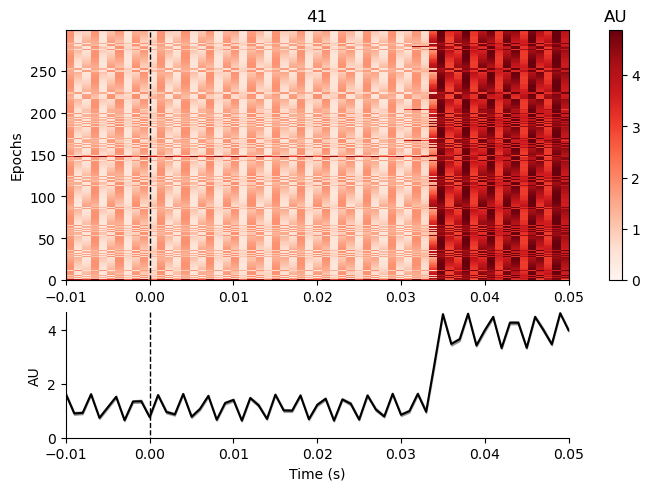

In [29]:
epochs_diode.plot_image(picks='41');

In [30]:
evokeds_diode = epochs_diode.average(picks='misc')

/tmp/ipykernel_346/2795768579.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(dict(stim=evokeds_diode), picks='misc', vlines=[0, .033]);


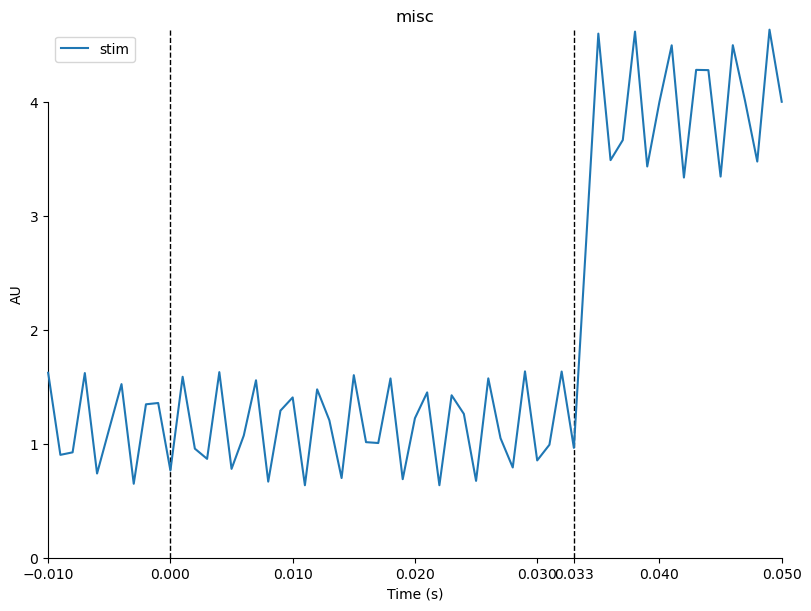

In [31]:
# plotting the averaged diode response across all trials
# - adding a vertical line at 33 ms to illustrate the 2-frame delay
mne.viz.plot_compare_evokeds(dict(stim=evokeds_diode), picks='misc', vlines=[0, .033]);

# Re-adjusting timing (based on diode timing check from above)
Adding 33 ms (= 2 frames) to all trigger timestamps (except the very first trigger which marks the beginning of the file)

In [32]:
# creating a copy of the events-structure so that we can compare with the original events-structure
# after compensation/re-adjusment
events_diode = events.copy()

In [33]:
# having a quick look at the events-strucutre
events_diode[:20, :]

array([[    0,     0, 99999],
       [ 7159,     0,    50],
       [13651,     0,   200],
       [15650,     0,   200],
       [17650,     0,   200],
       [19651,     0,   100],
       [21650,     0,   200],
       [23651,     0,   200],
       [25651,     0,   200],
       [27651,     0,   200],
       [29650,     0,   200],
       [31651,     0,   100],
       [33650,     0,   200],
       [35651,     0,   200],
       [37651,     0,   100],
       [39651,     0,   100],
       [41651,     0,   100],
       [43651,     0,   200],
       [45651,     0,   200],
       [47651,     0,   200]])

In [34]:
# adding our delay to all timestamps in our event structure (which just marks the beginning of the recording)
events[1:-1,0] = events[1:-1,0]+33

In [35]:
# having a quick look to see that all timestamps have changed accordingly
print(events_diode[:10,:])
print(events[:10,:])
print(events[:10,0]-events_diode[:10,0])

[[    0     0 99999]
 [ 7159     0    50]
 [13651     0   200]
 [15650     0   200]
 [17650     0   200]
 [19651     0   100]
 [21650     0   200]
 [23651     0   200]
 [25651     0   200]
 [27651     0   200]]
[[    0     0 99999]
 [ 7192     0    50]
 [13684     0   200]
 [15683     0   200]
 [17683     0   200]
 [19684     0   100]
 [21683     0   200]
 [23684     0   200]
 [25684     0   200]
 [27684     0   200]]
[ 0 33 33 33 33 33 33 33 33 33]


## quick round of epoching and plotting to inspect the effect of re-adjusting the timeline wrt the triggers

In [36]:
# for ERPs
tmin, tmax = -0.1, 0.8  # in s

epochs_adjust = mne.Epochs(
    raw,
    events=events, # using the updated events-timestamps
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    verbose=False,
)

In [37]:
# for ERPs
tmin, tmax = -0.1, 0.8  # in s

epochs_orig = mne.Epochs(
    raw,
    events=events_diode, # using the original events-timestamps
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    verbose=False,
)

## Subsetting

In [38]:
std_adjust = epochs_adjust['Standard']
dev_adjust = epochs_adjust['Deviant']

std_orig = epochs_orig['Standard']
dev_orig = epochs_orig['Deviant']

## Plotting epochs

Using data from preloaded Raw for 299 events and 901 original time points ...
0 bad epochs dropped
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


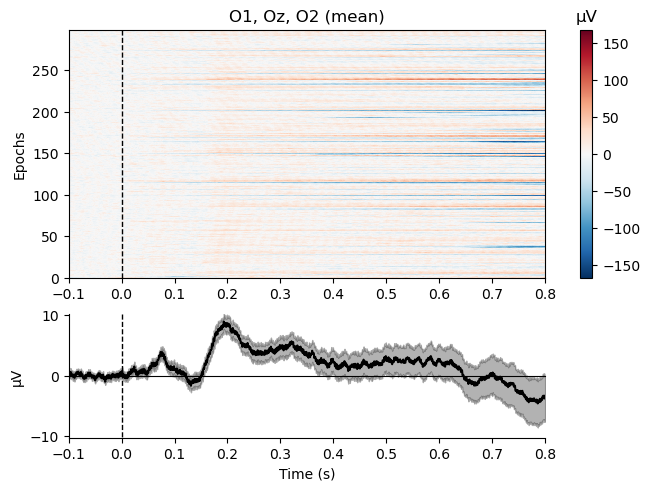

Using data from preloaded Raw for 299 events and 901 original time points ...
0 bad epochs dropped
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


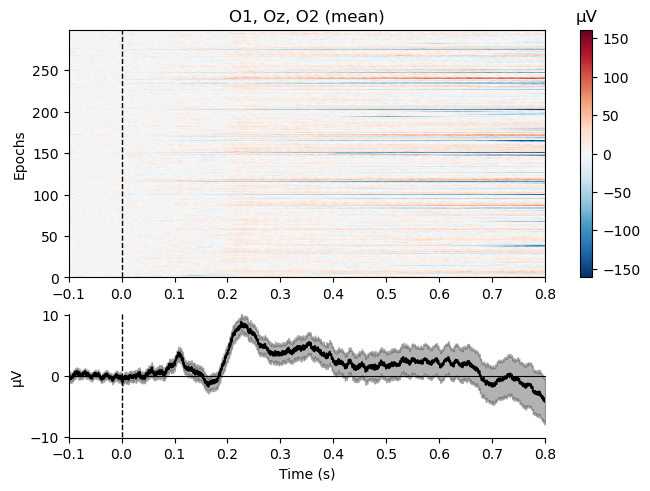

In [39]:
# plotting from channels over occipital cortex (looking for P1-N1-P2)
picks = ['O1','Oz','O2']
epochs_adjust.plot_image(picks=picks, combine='mean');
epochs_orig.plot_image(picks=picks, combine='mean');

Using data from preloaded Raw for 57 events and 901 original time points ...
Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


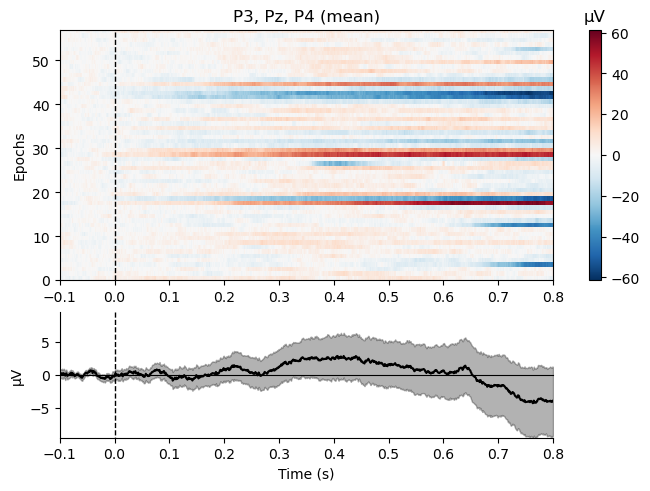

Using data from preloaded Raw for 57 events and 901 original time points ...
Not setting metadata
57 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


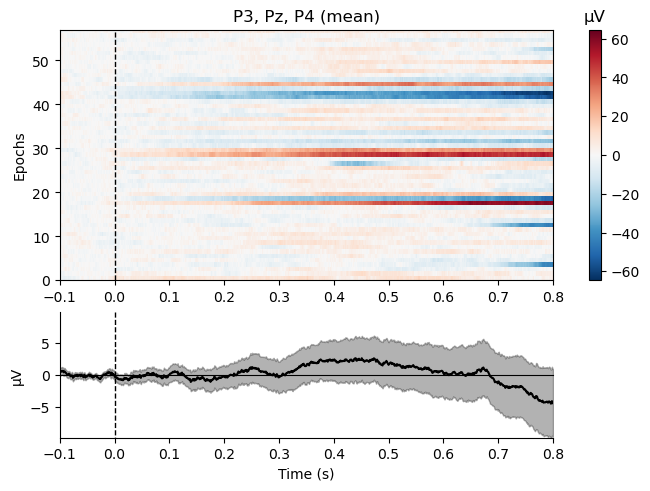

In [45]:
# plotting from channels over parietal cortex (potential P3) - and only the deviants
picks = ['P3','Pz','P4']
dev_adjust.plot_image(picks=picks, combine='mean');
dev_orig.plot_image(picks=picks, combine='mean');

# Evoked

In [57]:
evoked_std_adjust = std_adjust.average()
evoked_std_orig = std_orig.average()

evoked_dev_adjust = dev_adjust.average()
evoked_dev_orig = dev_orig.average()

evoked_adjust = epochs_adjust.average()
evoked_orig = epochs_orig.average()

No projector specified for this dataset. Please consider the method self.add_proj.


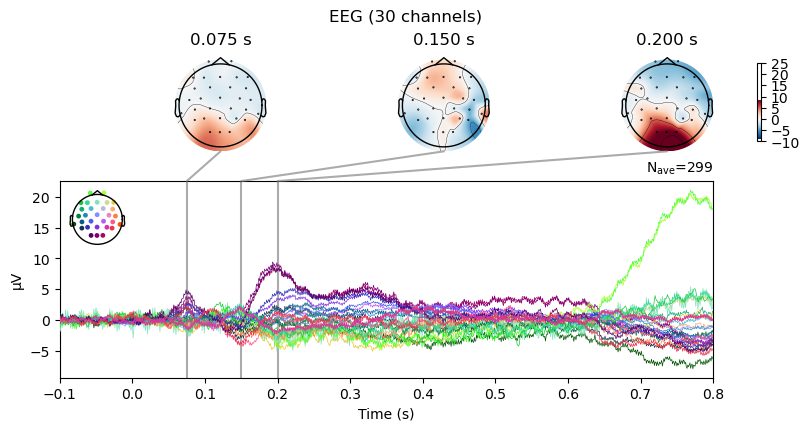

No projector specified for this dataset. Please consider the method self.add_proj.


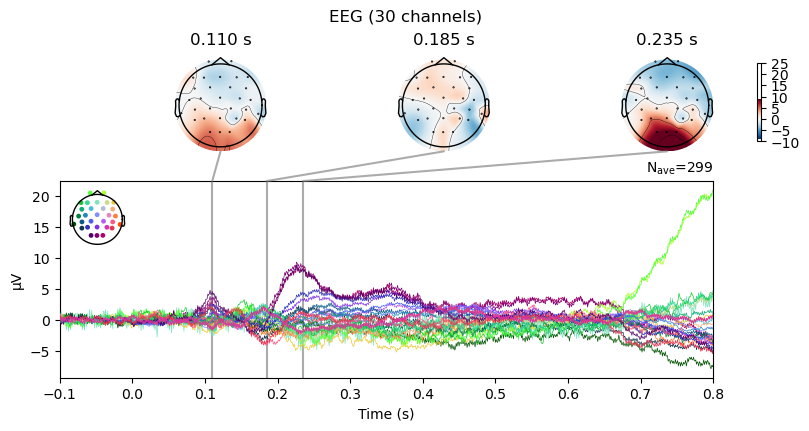

In [53]:
times_adjust = [0.075, 0.15, 0.2]
times_orig = [0.11, 0.185, 0.235]

evoked_adjust.plot_joint(times=times_adjust);
evoked_orig.plot_joint(times=times_orig);

No projector specified for this dataset. Please consider the method self.add_proj.


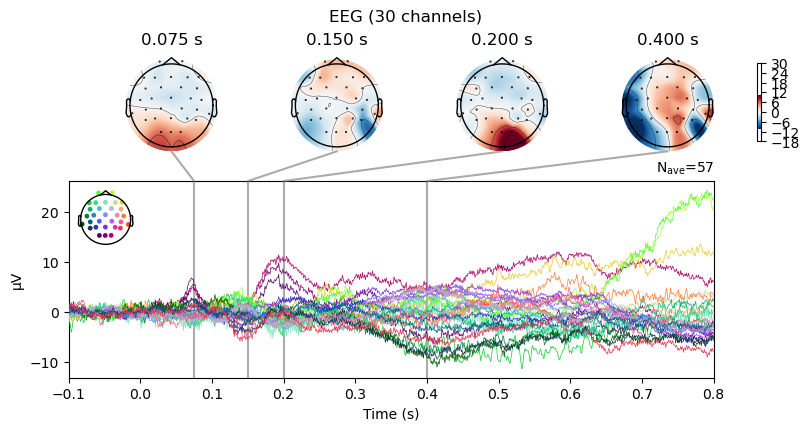

No projector specified for this dataset. Please consider the method self.add_proj.


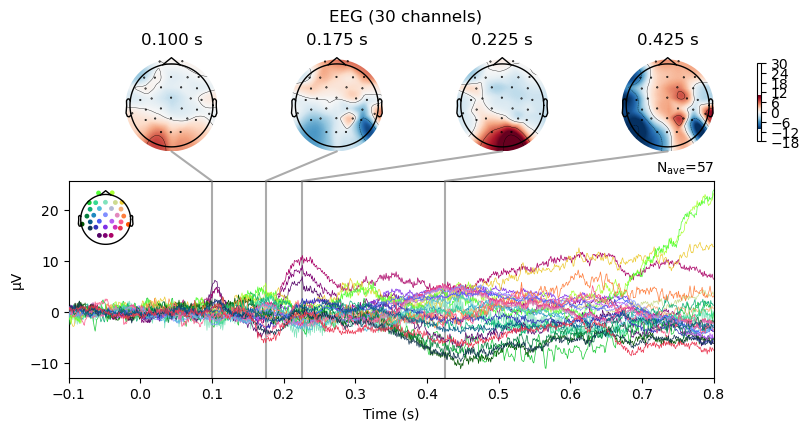

In [54]:
times_adjust = [0.075, 0.15, 0.2, 0.4]
times_orig = [0.1, 0.175, 0.225, 0.425]

evoked_dev_adjust.plot_joint(times=times_adjust);
evoked_dev_orig.plot_joint(times=times_orig);

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


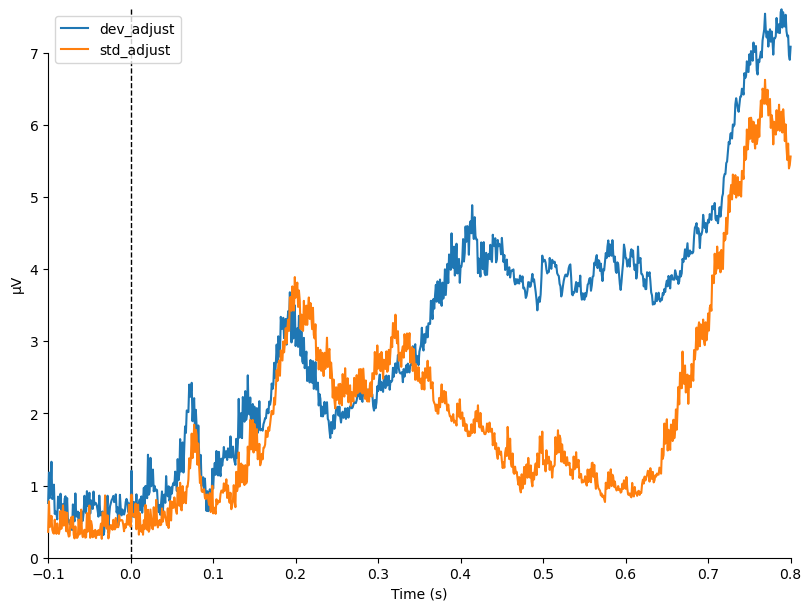

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


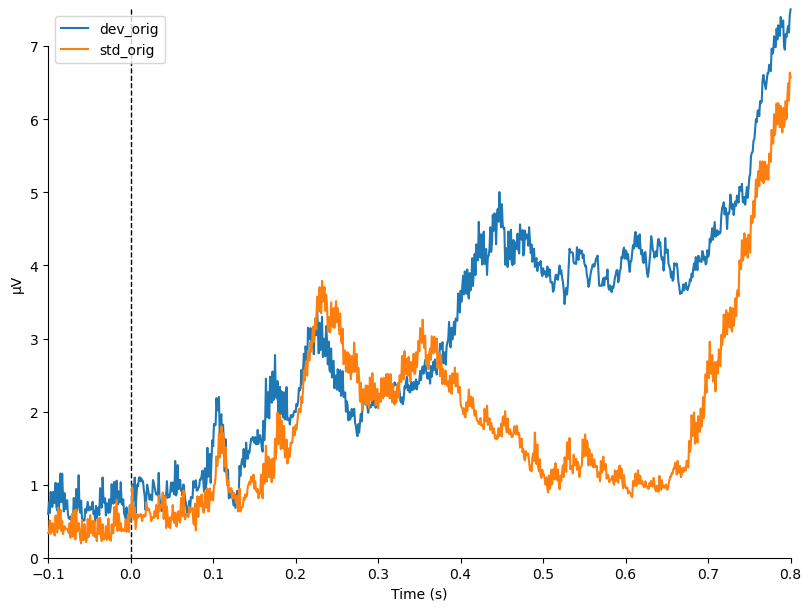

combining channels using "mean"
combining channels using "mean"


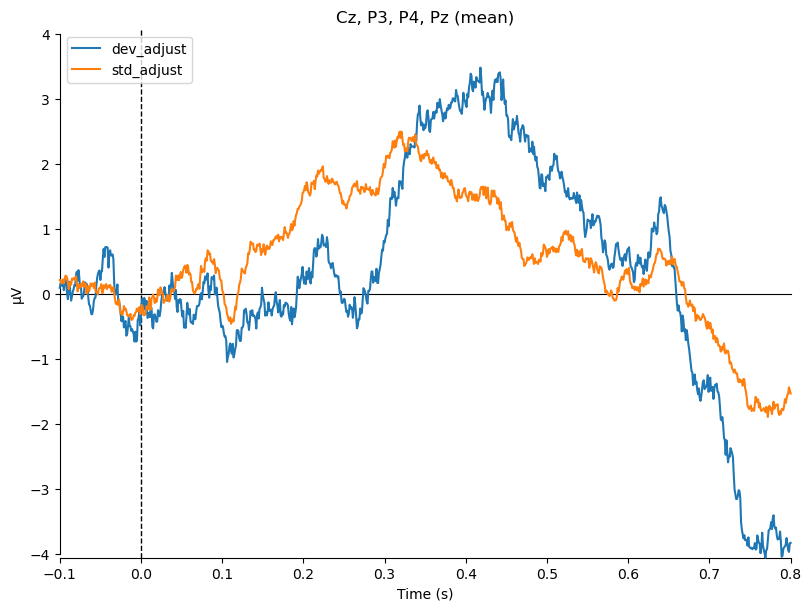

combining channels using "mean"
combining channels using "mean"


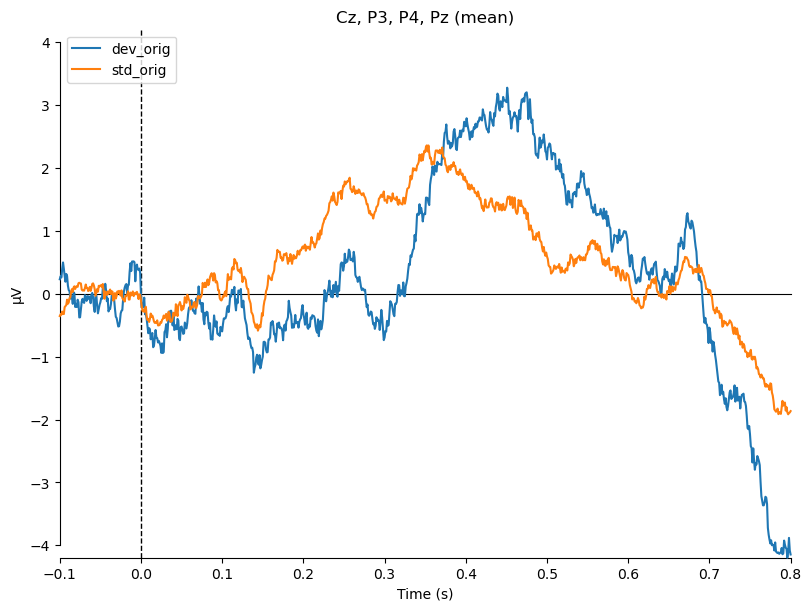

[<Figure size 800x600 with 1 Axes>]

In [58]:
# Plotting GFP across all channels
mne.viz.plot_compare_evokeds(dict(dev_adjust=evoked_dev_adjust, std_adjust=evoked_std_adjust))
mne.viz.plot_compare_evokeds(dict(dev_orig=evoked_dev_orig, std_orig=evoked_std_orig))

# Plotting combine='mean' for a selection of channels
picks = ['Cz', 'P3', 'P4', 'Pz']
mne.viz.plot_compare_evokeds(dict(dev_adjust=evoked_dev_adjust, std_adjust=evoked_std_adjust),
                            picks=picks, combine='mean')
mne.viz.plot_compare_evokeds(dict(dev_orig=evoked_dev_orig, std_orig=evoked_std_orig),
                            picks=picks, combine='mean')
